In [195]:
import pandas as pd
data=pd.read_csv('../raw_data/Tool_Info.csv')
data['age']=2019-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95

# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data.head()

,ID,aligner,url,year_of_pub,application,indexing,fix_length_seed,spaced_seed,seed_chaining,pairwise_alignment,...,num_citations,wrapper,wrapper_of,age,citation_per_year,index,pairwise,seeds_fixed,seeds_chained,seeds_spaced
0,104,BatMeth2,https://github.com/GuoliangLi-HZAU/BatMeth2/,2019,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,2,N,NaN,1,2.000000,BWT-FM,Multiple Methods,Yes,Yes,No
1,63,BS-Seeker2,https://github.com/BSSeeker/BSseeker2,2013,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,173,Y,Bowtie2,7,24.714286,BWT-FM,Multiple Methods,Yes,Yes,No
2,54,BRAT-BW,http://compbio.cs.ucr.edu/brat/,2012,BS-Seq,BWT-FM,N,N,N,HD,...,70,N,NaN,8,8.750000,BWT-FM,Hamming Distance,No,No,No
3,43,Bismark,https://github.com/FelixKrueger/Bismark,2011,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,1550,Y,Bowtie2 or HISAT2,9,172.222222,BWT-FM,Multiple Methods,Yes,Yes,No
4,32,BS-Seeker,https://github.com/BSSeeker/BSseeker2,2010,BS-Seq,BWT-FM,Y,N,N,HD,...,215,Y,Bowtie,10,21.500000,BWT-FM,Hamming Distance,Yes,No,No


In [44]:
rt = pd.read_csv('../raw_data/compare.tools.runtime.hours.csv')
idx_rt = pd.read_csv('../raw_data/compare.tools.index.csv')
mem = pd.read_csv('../raw_data/compare.tools.memory.csv')

In [74]:
data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 
                        'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']])
data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()
rt.loc[:,'tools_lower'] = rt.loc[:,'Tools'].str.lower()
rtyear = pd.merge(rt, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
rtyear.loc[:,'average_runtime'] = rtyear.iloc[:,1:11].mean(axis=1)
rtyear.loc[:,'std_dev'] = rtyear.iloc[:,1:11].std(axis=1)

# Imputing the one missing value
rtyear.loc[3,'ERR162843'] = rtyear.loc[3,'average_runtime'] 

# Only compare tools with DNA application
rtyear = rtyear.loc[rtyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)

# Bowtie2 can be run in global or local, our data was generated using Needleman-Wunsch (Global)
rtyear.loc[rtyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
rtyear_summ = rtyear.loc[:,['aligner', 'year_of_pub', 'average_runtime', 'std_dev', 'application', 
                            'index', 'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']]
rtyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    if rtyear.loc[i,'year_of_pub'] < 2013:
        rtyear.loc[i,'year_split'] = 'Before 2013'  
    else:
        rtyear.loc[i,'year_split'] = '2013 and later'
rtyear_melt = pd.melt(rtyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'runtime')
rtyear.to_csv(path_or_buf='../summary_data/runtime_comparison_with_tool_info.csv')
rtyear_summ

,aligner,year_of_pub,average_runtime,std_dev,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained
7,RMAP,2008,12.950420,4.114427,DNA,Hashing,Hamming Distance,Yes,No,No
1,Bowtie,2009,6.102213,2.942134,DNA,BWT-FM,Hamming Distance,Yes,No,No
2,BWA,2009,6.239311,2.106996,DNA,BWT-FM,Other DP,No,No,No
3,GSNAP,2010,20.924469,10.347573,DNA,Hashing,Non-DP Heuristic,Yes,No,Yes
8,SMALT,2010,32.163790,14.049867,DNA,Hashing,Smith-Waterman,Yes,No,Yes
5,LAST,2011,20.221401,7.627339,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No
9,SNAP,2011,1.165595,0.387181,DNA,Hashing,Needleman-Wunsch,Yes,No,No
0,Bowtie2,2012,4.973138,2.040406,DNA,BWT-FM,Needleman-Wunsch,Yes,No,Yes
10,Subread,2013,1.245445,0.488954,DNA/RNA-Seq,Hashing,Smith-Waterman,Yes,Yes,Yes
6,minimap2,2018,1.866426,0.694104,DNA/RNA-Seq,Hashing,Needleman-Wunsch,Yes,No,Yes


In [46]:
data_cite = pd.DataFrame(data.loc[:,['citation_per_year', 'aligner', 'application', 'index', 'pairwise']])
data_cite.loc[:,'aligner_lower'] = data_cite['aligner'].str.lower()
rt.loc[:,'tools_lower'] = rt['Tools'].str.lower()
rtcite = pd.merge(rt, data_cite, left_on='tools_lower', right_on='aligner_lower', how='inner')

rtcite.loc[:,'average_runtime'] = rtcite.iloc[:,1:11].mean(axis=1)
rtcite.loc[:,'std_dev_rt'] = rtcite.iloc[:,1:11].std(axis=1)
rtcite.loc[3,'ERR162843'] = rtcite.loc[3,'average_runtime']
rtcite = rtcite.loc[rtcite.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)

rtcite_melt = pd.melt(rtcite, id_vars = ['aligner', 'citation_per_year', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'runtime')
rtcite_summ = rtcite.loc[:,['aligner', 'citation_per_year', 'average_runtime', 'std_dev_rt', 
                            'application', 'index', 'pairwise']]
rtcite_summ

,aligner,citation_per_year,average_runtime,std_dev_rt,application,index,pairwise
0,Bowtie2,2010.125000,4.973138,2.040406,DNA,BWT-FM,Multiple Methods
1,Bowtie,1353.636364,6.102213,2.942134,DNA,BWT-FM,Hamming Distance
2,BWA,1831.181818,6.239311,2.106996,DNA,BWT-FM,Other DP
3,GSNAP,154.900000,20.924469,10.347573,DNA,Hashing,Non-DP Heuristic
4,HISAT2,95.000000,1.158713,0.634037,DNA,BWT-FM,Non-DP Heuristic
5,LAST,62.777778,20.221401,7.627339,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods
6,minimap2,197.000000,1.866426,0.694104,DNA/RNA-Seq,Hashing,Needleman-Wunsch
7,RMAP,32.083333,12.950420,4.114427,DNA,Hashing,Hamming Distance
8,SMALT,2.700000,32.163790,14.049867,DNA,Hashing,Smith-Waterman
9,SNAP,14.555556,1.165595,0.387181,DNA,Hashing,Needleman-Wunsch


In [69]:
mem.loc[:,'tools_lower'] = mem['Tools'].str.lower()
memyear = pd.merge(mem, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
memyear.loc[:,'average_memory'] = memyear.iloc[:,1:11].mean(axis=1)
memyear = memyear.loc[memyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)
memyear.loc[memyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
memyear_summ = memyear.loc[:,['aligner', 'year_of_pub', 'average_memory', 'application', 'index', 
                             'pairwise','seeds_fixed','seeds_spaced', 'seeds_chained',]]
memyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    memyear.loc[i,'year_split'] = 'Before 2013' if memyear.loc[i,'year_of_pub'] < 2013 else '2013 and later'
    
memyear_melt = pd.melt(memyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'memory')
memyear.to_csv(path_or_buf='../summary_data/memory_comparison_with_tool_info.csv')
memyear_summ

,aligner,year_of_pub,average_memory,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained
7,RMAP,2008,9.5320,DNA,Hashing,Hamming Distance,Yes,No,No
1,Bowtie,2009,3.1940,DNA,BWT-FM,Hamming Distance,Yes,No,No
2,BWA,2009,5.7110,DNA,BWT-FM,Other DP,No,No,No
3,GSNAP,2010,28.8536,DNA,Hashing,Non-DP Heuristic,Yes,No,Yes
8,SMALT,2010,3.6766,DNA,Hashing,Smith-Waterman,Yes,No,Yes
5,LAST,2011,15.3589,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No
9,SNAP,2011,36.1000,DNA,Hashing,Needleman-Wunsch,Yes,No,No
0,Bowtie2,2012,3.5799,DNA,BWT-FM,Needleman-Wunsch,Yes,No,Yes
10,Subread,2013,8.1088,DNA/RNA-Seq,Hashing,Smith-Waterman,Yes,Yes,Yes
6,minimap2,2018,12.4488,DNA/RNA-Seq,Hashing,Needleman-Wunsch,Yes,No,Yes


In [71]:
mem.loc[:,'tools_lower'] = mem['Tools'].str.lower()
memcite = pd.merge(mem, data_cite, left_on='tools_lower', right_on='aligner_lower', how='inner')

memcite.loc[:,'average_memory'] = memcite.iloc[:,1:11].mean(axis=1)
memcite.loc[:,'std_dev_mem'] = memcite.iloc[:,1:11].std(axis=1)
memcite = memcite.loc[memcite.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)

memcite_melt = pd.melt(memcite, id_vars = ['aligner', 'citation_per_year', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'memory')
memcite_summ = memcite.loc[:,['aligner', 'citation_per_year', 'average_memory', 'std_dev_mem', 
                              'application', 'index', 'pairwise']]
memcite_summ

,aligner,citation_per_year,average_memory,std_dev_mem,application,index,pairwise
0,Bowtie2,2010.125000,3.5799,0.000316,DNA,BWT-FM,Multiple Methods
1,Bowtie,1353.636364,3.1940,0.000000,DNA,BWT-FM,Hamming Distance
2,BWA,1831.181818,5.7110,0.499966,DNA,BWT-FM,Other DP
3,GSNAP,154.900000,28.8536,1.453301,DNA,Hashing,Non-DP Heuristic
4,HISAT2,95.000000,4.6941,0.000316,DNA,BWT-FM,Non-DP Heuristic
5,LAST,62.777778,15.3589,0.002923,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods
6,minimap2,197.000000,12.4488,0.193869,DNA/RNA-Seq,Hashing,Needleman-Wunsch
7,RMAP,32.083333,9.5320,1.860403,DNA,Hashing,Hamming Distance
8,SMALT,2.700000,3.6766,0.001075,DNA,Hashing,Smith-Waterman
9,SNAP,14.555556,36.1000,0.779528,DNA,Hashing,Needleman-Wunsch


In [243]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

tool_clrs = ['teal', 'purple', 'palegreen', 'deepskyblue', 'magenta', 'maroon', 'khaki', 
        'darkorange', 'limegreen', 'turquoise', 'blue']

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

order_by_year = ["RMAP", "Bowtie", "BWA", "GSNAP", "SMALT", "LAST", "SNAP", "Bowtie2", "Subread", "HISAT2", "minimap2"]

sns.set_style('white')
sns.set_context('talk')

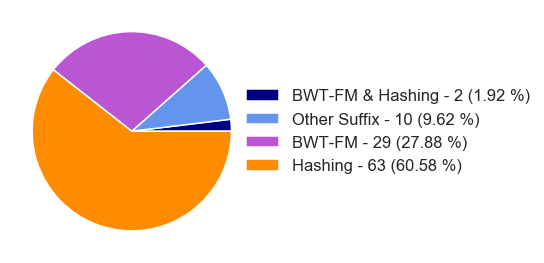

In [244]:
plt.figure(figsize=(11,4))
sns.set_style('white')
sns.set_context('talk')
idx_group = data_year.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
plt.savefig('../figures/Figure2_a_0.png')
plt.savefig('../figures/Figure2_a_0.pdf')

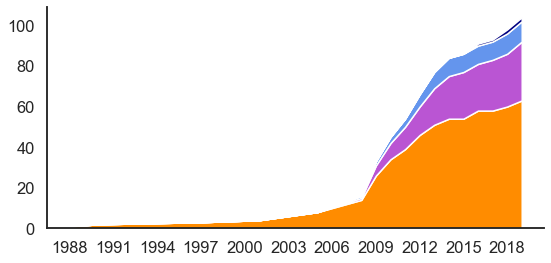

In [245]:
plt.figure(figsize=(8,4))
by_year = data_year.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index
by_year

sns.set_style('white')
sns.set_context('talk')

plt.stackplot(x, by_year.loc[:,'Hashing'], by_year.loc[:,'BWT-FM'], by_year.loc[:,'Other Suffix'], 
              by_year.loc[:,'BWT-FM & Hashing'], 
              labels=['Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'], colors=index_clrs)
#plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(x), max(x)+1, 3))
#plt.show()
sns.despine()

plt.tight_layout()
plt.savefig('../figures/Figure2_a_1.png')
plt.savefig('../figures/Figure2_a_1.pdf')

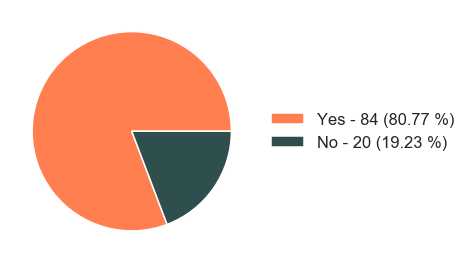

In [246]:
plt.figure(figsize=(12,4))

FLS_group = data_year.groupby('seeds_fixed').count().sort_values('aligner', ascending=False)
patches, texts = plt.pie(FLS_group.aligner, colors=['coral', 'darkslategray'])
pct = 100.*FLS_group.aligner/FLS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(FLS_group.index, FLS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_b_0.png')
plt.savefig('../figures/Figure2_b_0.pdf')

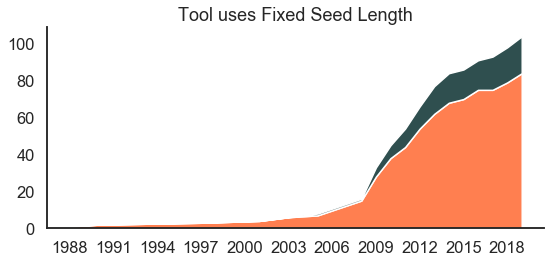

In [247]:
plt.figure(figsize=(8,4))
by_year = data_year.groupby(['year_of_pub','seeds_fixed']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index

sns.set_style('white')
sns.set_context('talk')

plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
              labels=['Yes', 'No'], colors=['coral', 'darkslategray'])
sns.despine()
plt.xticks(range(min(x), max(x)+1, 3))
plt.title('Tool uses Fixed Seed Length')
plt.tight_layout()

#plt.show()
plt.savefig('../figures/Figure2_b_1.png')
plt.savefig('../figures/Figure2_b_1.pdf')

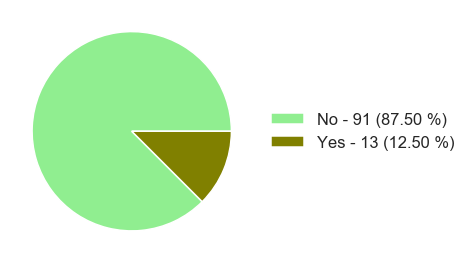

In [248]:
plt.figure(figsize=(12,4))

SS_group = data_year.groupby('seeds_spaced').count().sort_values('aligner', ascending=False)
patches, texts = plt.pie(SS_group.aligner, colors=['lightgreen','olive'])
pct = 100.*SS_group.aligner/SS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(SS_group.index, SS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_c_0.png')
plt.savefig('../figures/Figure2_c_0.pdf')

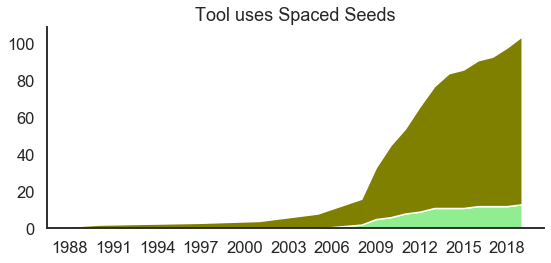

In [249]:
plt.figure(figsize=(8,4))
by_year = data_year.groupby(['year_of_pub','seeds_spaced']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index


sns.set_style('white')
sns.set_context('talk')
plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
              labels=['Yes', 'No'], colors=['lightgreen','olive'])

plt.xticks(range(min(x), max(x)+1, 3))
plt.title('Tool uses Spaced Seeds')
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_c_1.png')
plt.savefig('../figures/Figure2_c_1.pdf')

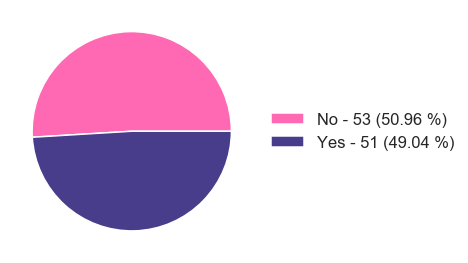

In [250]:
plt.figure(figsize=(12,4))

CS_group = data_year.groupby('seeds_chained').count().sort_values('aligner', ascending=False)
patches, texts = plt.pie(CS_group.aligner, colors=['hotpink','darkslateblue'])
pct = 100.*CS_group.aligner/CS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(CS_group.index, CS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_d_0.png')
plt.savefig('../figures/Figure2_d_0.pdf')

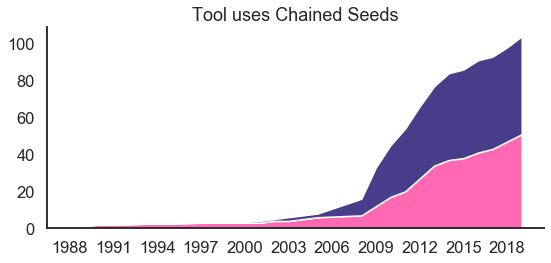

In [251]:
plt.figure(figsize=(8,4))
by_year = data_year.groupby(['year_of_pub','seeds_chained']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index

sns.set_style('white')
sns.set_context('talk')
plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
              labels=['Yes', 'No'], colors=['hotpink','darkslateblue'])

plt.xticks(range(min(x), max(x)+1, 3))
plt.title('Tool uses Chained Seeds')
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_d_1.png')
plt.savefig('../figures/Figure2_d_1.pdf')

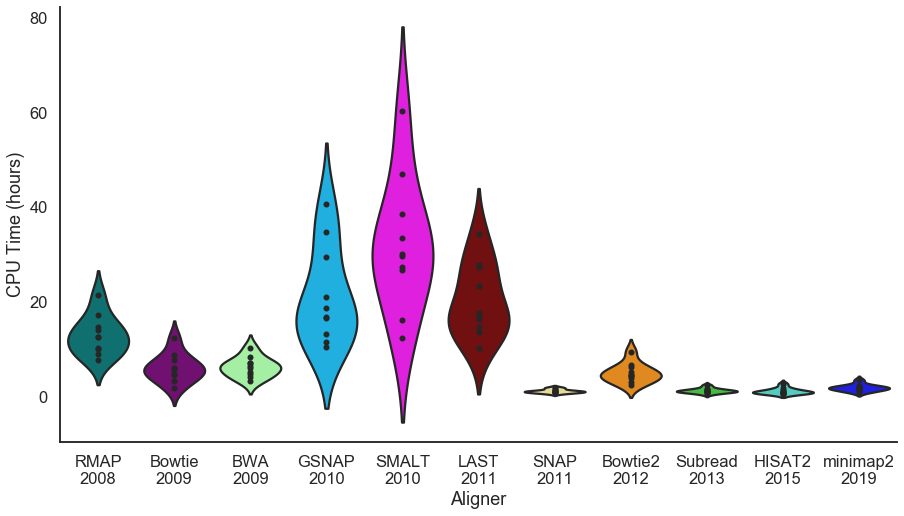

In [252]:
plt.figure(figsize=(15,8))
my_order = rtyear_melt.groupby(by='aligner')[["runtime"]].median()
my_order = my_order.sort_values(by='runtime').index

sns.set_style('white')
sns.set_context('talk')
ax = sns.violinplot(data = rtyear_melt, x = 'aligner', y = 'runtime', scale='width', palette=tool_clrs,# color = "grey"
                   order = order_by_year, inner='points')
ax.set(xlabel = 'Aligner', ylabel = 'CPU Time (hours)')
ax.set_xticklabels(#rotation=40, ha="right", 
                   labels=["RMAP\n2008", "Bowtie\n2009", "BWA\n2009", "GSNAP\n2010", "SMALT\n2010", "LAST\n2011", 
                           "SNAP\n2011", "Bowtie2\n2012", "Subread\n2013", "HISAT2\n2015", "minimap2\n2019"])
sns.despine()
#plt.show()
plt.savefig('../figures/Figure2_e_0.png')
plt.savefig('../figures/Figure2_e_0.pdf')

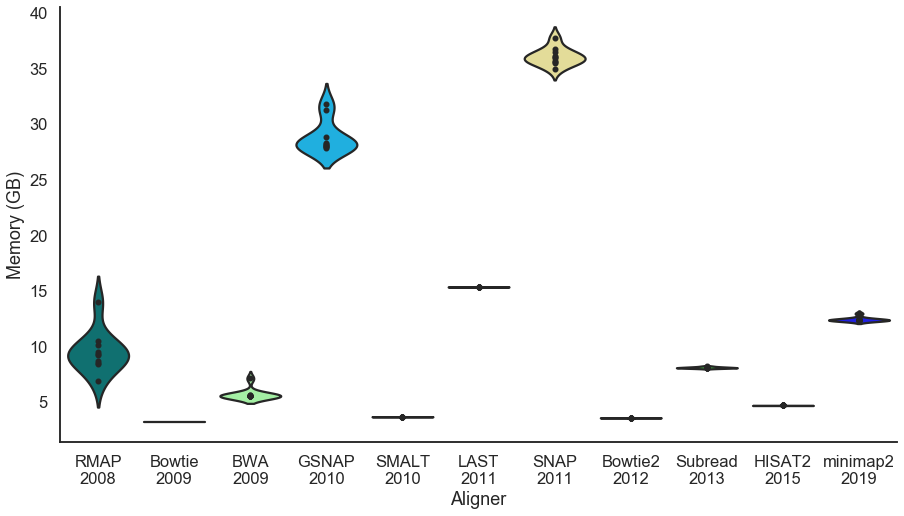

In [253]:
plt.figure(figsize=(15,8))

sns.set_style('white')
sns.set_context('talk')
ax = sns.violinplot(data = memyear_melt, x = 'aligner', y = 'memory', scale='width', palette=tool_clrs,# color="grey",
                    order=order_by_year, inner='points')
ax.set(xlabel = 'Aligner', ylabel = 'Memory (GB)')
ax.set_xticklabels(#rotation=40, ha="right", 
                   labels=["RMAP\n2008", "Bowtie\n2009", "BWA\n2009", "GSNAP\n2010", "SMALT\n2010", "LAST\n2011", 
                           "SNAP\n2011", "Bowtie2\n2012", "Subread\n2013", "HISAT2\n2015", "minimap2\n2019"])

sns.despine()
#plt.show()
plt.savefig('../figures/Figure2_e_1.png')
plt.savefig('../figures/Figure2_e_1.pdf')

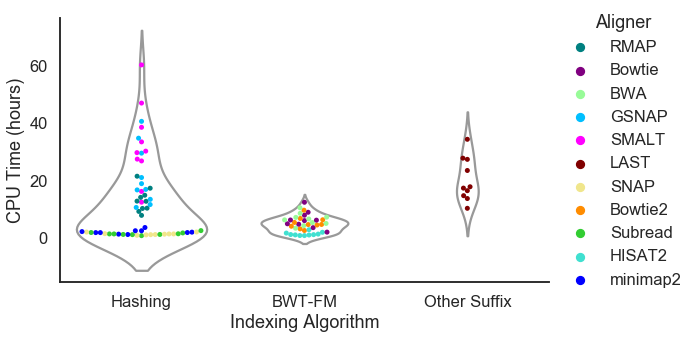

In [254]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.violinplot(data = rtyear_melt, x = 'index', y = 'runtime', scale="count",
                 order=['Hashing','BWT-FM','Other Suffix'], color="1", inner=None)
ax = sns.swarmplot(data = rtyear_melt, x = 'index', y = 'runtime',
                   order=['Hashing','BWT-FM','Other Suffix'], 
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year)#, size=8, jitter=.3)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)

sns.despine()
plt.tight_layout()
#plt.show()
plt.savefig('../figures/Figure2_f_0.png')
plt.savefig('../figures/Figure2_f_0.pdf')

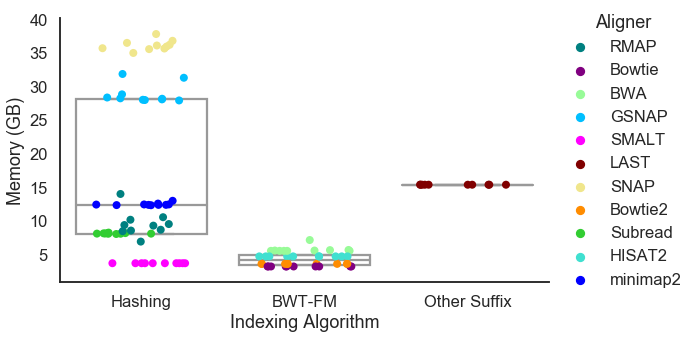

In [255]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data = memyear_melt, x = 'index', y = 'memory', order=['Hashing','BWT-FM','Other Suffix'],
                 color="1", fliersize=0, whis=0)
ax = sns.stripplot(data = memyear_melt, x = 'index', y = 'memory', order=['Hashing','BWT-FM','Other Suffix'],
                  palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure2_f_1.png')
plt.savefig('../figures/Figure2_f_1.pdf')

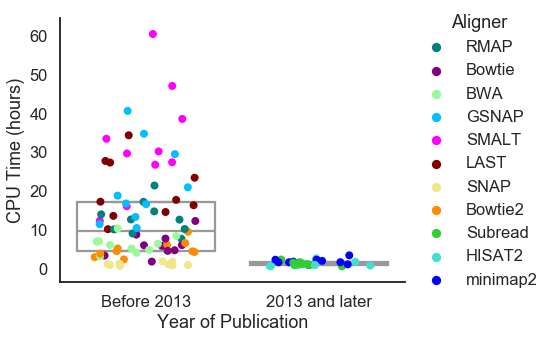

In [256]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data = rtyear_melt, x = 'year_split', y = 'runtime', whis=0,
                 order = ['Before 2013', '2013 and later'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtyear_melt, x = 'year_split', y = 'runtime', order=['Before 2013','2013 and later'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3)
ax.set(xlabel = 'Year of Publication', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_g_0.png')
plt.savefig('../figures/Figure2_g_0.pdf')

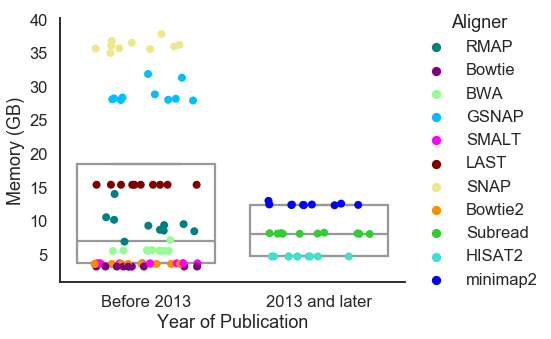

In [257]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data = memyear_melt, x = 'year_split', y = 'memory', whis=0, fliersize=0,
                 order = ['Before 2013', '2013 and later'], color="1")
ax = sns.stripplot(data = memyear_melt, x = 'year_split', y = 'memory', order=['Before 2013','2013 and later'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3)
ax.set(xlabel = 'Year of Publication', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure2_g_1.png')
plt.savefig('../figures/Figure2_g_1.pdf')

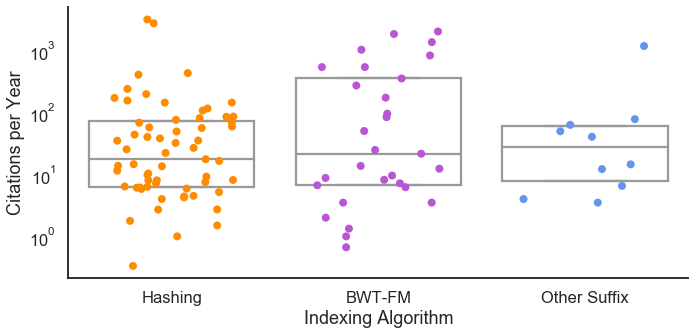

In [258]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data=data_cite, x='index', y='citation_per_year', whis=0, 
                 order=['Hashing','BWT-FM','Other Suffix'], color="1", fliersize=0)
ax = sns.stripplot(data = data_cite, x = 'index', y = 'citation_per_year', 
                   order=['Hashing','BWT-FM','Other Suffix'], palette=index_clrs, size=8, jitter=.3)
ax.set(xlabel = 'Indexing Algorithm', ylabel = "Citations per Year", yscale="log")
#ax.set_xticklabels(rotation=40, ha="right")
plt.tight_layout()
sns.despine()
#plt.show()

plt.savefig('../figures/Figure2_h_0.png')
plt.savefig('../figures/Figure2_h_0.pdf')

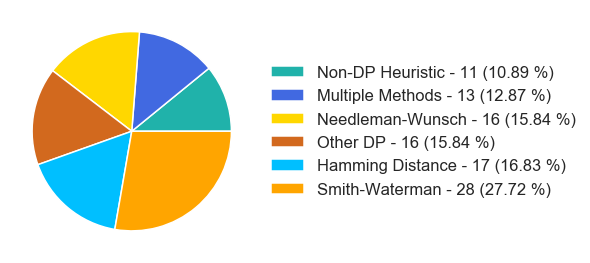

In [259]:
plt.figure(figsize=(12,4))

sns.set_style('white')
sns.set_context('talk')
pairwise_group = data_year.groupby('pairwise').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(pairwise_group.aligner, colors=local_clrs[::-1])
pct = 100.*pairwise_group.aligner/pairwise_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(pairwise_group.index, pairwise_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure2_i_0.png')
plt.savefig('../figures/Figure2_i_0.pdf')

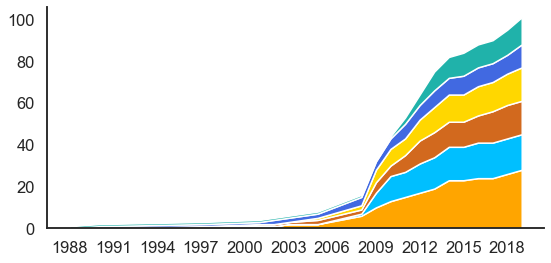

In [260]:
plt.figure(figsize=(8,4))

by_year = data_year.groupby(['year_of_pub','pairwise']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
x = by_year.index

sns.set_style('white')
sns.set_context('talk')
plt.stackplot(x, by_year.loc[:,'Smith-Waterman'], by_year.loc[:,'Hamming Distance'], 
              by_year.loc[:,'Needleman-Wunsch'], by_year.loc[:,'Other DP'], 
              by_year.loc[:,'Non-DP Heuristic'], by_year.loc[:,'Multiple Methods'],
              labels=['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP',
                      'Non-DP Heuristic', 'Multiple Methods'], colors=local_clrs)
#plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(x), max(x)+1, 3))
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure2_i_1.png')
plt.savefig('../figures/Figure2_i_1.pdf')

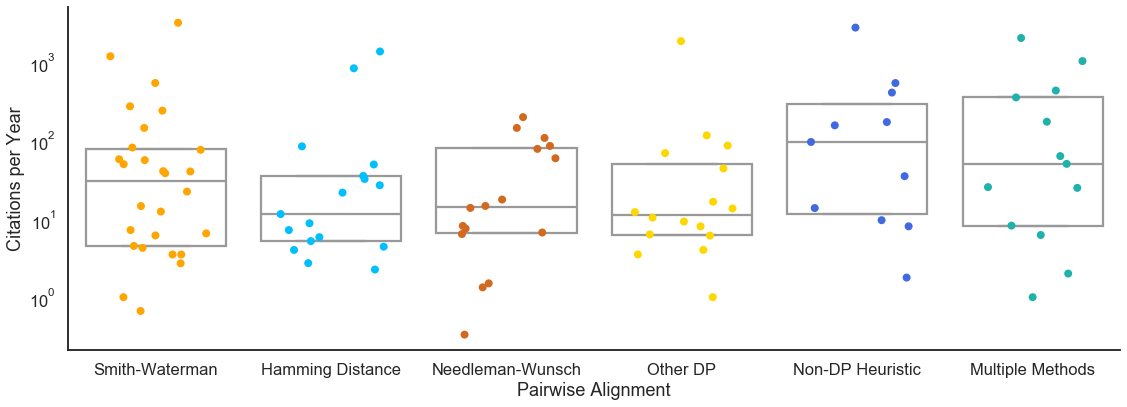

In [261]:
plt.figure(figsize=(16,6))

sns.set_style('white')
sns.set_context('talk')
ax = sns.boxplot(data=data_cite, x='pairwise', y='citation_per_year',  
                order=['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP', 'Non-DP Heuristic',
                     'Multiple Methods'], color="1", fliersize=0, whis=0)
ax = sns.stripplot(data=data_cite, x='pairwise', y='citation_per_year',  
                order=['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP', 'Non-DP Heuristic',
                     'Multiple Methods'], palette=local_clrs, size=8, jitter=.3)
ax.set(xlabel = 'Pairwise Alignment', ylabel = "Citations per Year", yscale="log")
plt.tight_layout()
sns.despine()
#ax.set_xticklabels(rotation=40, ha="right")
#plt.show()
plt.savefig('../figures/Figure2_j_0.png')
plt.savefig('../figures/Figure2_j_0.pdf')

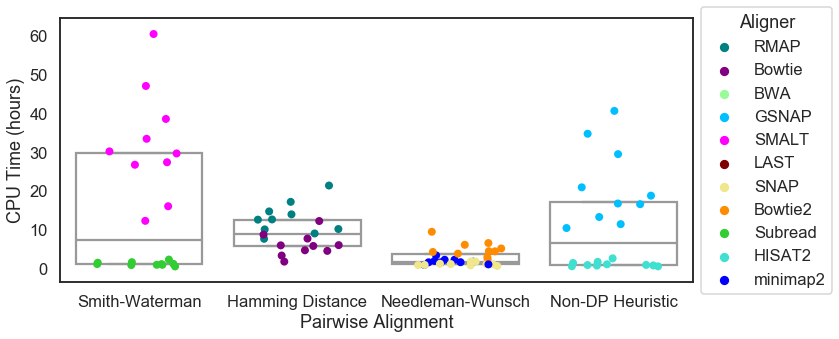

In [263]:
plt.figure(figsize=(12,5))
ax = sns.boxplot(data = rtyear_melt, x = 'pairwise', y = 'runtime', 
                 order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'], 
                 fliersize=0, color="1", whis=0)
ax = sns.stripplot(data = rtyear_melt, x = 'pairwise', y = 'runtime', 
                   order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'],
                   hue="aligner", hue_order=order_by_year, palette=tool_clrs, size=8, jitter=.3)
ax.set(xlabel = 'Pairwise Alignment', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5))

plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_k_0.png')
plt.savefig('../figures/Figure2_k_0.pdf')

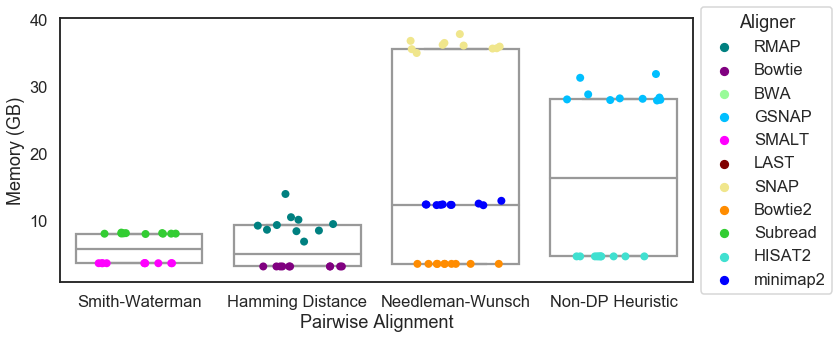

In [264]:
plt.figure(figsize=(12,5))
ax = sns.boxplot(data = memyear_melt, x = 'pairwise', y = 'memory',
                 order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'], 
                 color="1", fliersize=0, whis=0) 
ax = sns.stripplot(data = memyear_melt, x = 'pairwise', y = 'memory', 
                   order=['Smith-Waterman','Hamming Distance','Needleman-Wunsch','Non-DP Heuristic'],
                   hue="aligner", hue_order=order_by_year, palette=tool_clrs, size=8, jitter=.3)
ax.set(xlabel = 'Pairwise Alignment', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5))
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_k_1.png')
plt.savefig('../figures/Figure2_k_1.pdf')